In [10]:
import warnings
warnings.filterwarnings('ignore') # 実行に影響のない　warninig　を非表示にします. 非推奨.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# 7. PyMC3による（ベイズ）線形回帰
確率的モデリング用ライブラリとして有名な**PyMC3**を利用して線形回帰を行ってみる<br>
## 7-1. ライブラリのダウンロード！！
```
conda install -c conda-forge pymc3
```
実験時のバージョンは3.10.0

In [2]:
import pymc3 as pm
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.10.0


## 7-2. データセットをダウンロード&データの準備

In [8]:
wine = pd.read_csv("./data/winequality-red.csv", sep=";") # sepは区切り文字の指定
display(wine.head(5))
np.random.seed(0) # random　の挙動を固定

X = wine[["density"]].values
T = wine["alcohol"].values
X = X - X.mean()
T = T - T.mean()

#X, Tそれぞれが最小値0, 最大値1になるように標準化
#追加の前処理部分
X = (X - X.min()) / (X.max() - X.min())
T = (T - T.min()) / (T.max() - T.min())

p = np.random.permutation(len(X))
X = X[p]
T = T[p]

X_train = X[:1000, :]
T_train = T[:1000]
X_test = X[1000:, :]
T_test = T[1000:]

data = dict(x=X_train, y=T_train)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


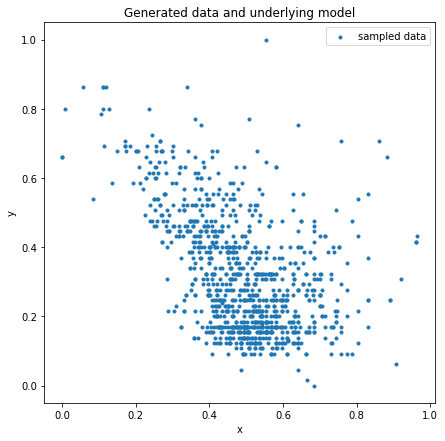

In [9]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.scatter(X_train, T_train, marker=".", label="sampled data")
plt.legend(loc=0);

## 7-3. モデル構築から事後分布導出まで
pytorchではどんなlossを使用するのか，いつ学習を行うのか，データはいくつに分割するのか，などを一つ一つ丁寧に定義していきました．<br>
しかしながら尤度最大化を最終目的とする確率モデリングでは（基本的に）それぞれのパラメータが従う分布さえ与えてやれば損失関数などは与える必要がありません．<br>
事前知識や既知の事実をパラメータとして与えることができる上に記述が簡素で読みやすいのがPyMC3の特徴です．**ただし計算量は大きい**<br><br>
以下では先ほどのwineデータに対して
$$
\begin{eqnarray}
p({\bf t|w}) &=& \prod_{n=1}^N{\mathcal N}(t_n|{\bf w^{\rm T}x}, \lambda)\\
p({\bf w}) &=& {\mathcal N}({\bf w|0}, {\bf 1})\\
p(\lambda) &=& {\rm Gamma}(\lambda|mu=1, sigma=0,2)
\end{eqnarray}
$$
と言う分布を仮定して回帰を行ってみます．<br>
データに対してフィットするように事後分布を求めるのが目標ですが，こちらも**基本的に解析的に求めれない**ことを仮定しているので**MCMC**とよばれる手法を使用して事後分布を求めています．これについてはまだ先で学ぶことだと思うので，今は**非解析的に事後分布を求める手法**とざっくり考えておいてもらっても良いかと思います．
<br>（ガンマ分布のパラメータとして今回は平均，分散を与えました．もちろん$\alpha, \beta$での初期化も可能です．）

In [22]:
inf = 10000


with pm.Model() as model:#以下のコードブロック中でそれぞれの分布を定義する
    #各パラメータの分布定義
    sigma = pm.Gamma("sigma", mu=1, sigma=0.2)#データの分散に対する事前分布
    intercept = pm.Normal("Intercept", 0, sigma=1)#切片に対する事前分布
    x_coeff = pm.Normal("x_coeff", 0, sigma=1)#係数に関する事前分布
    x = pm.Data("x", X_train.reshape(-1))
    t = pm.Data("t", T_train.reshape(-1))
    #尤度定義
    likelihood = pm.Normal("y", mu=intercept + x_coeff * x, sigma=sigma, observed=t)
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_coeff, Intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8834127071448987, but should be close to 0.8. Try to increase the number of tuning steps.


## 7-4. パラメータ事後分布の可視化
では実際に推論の結果求まった事後分布を

<Figure size 504x504 with 0 Axes>

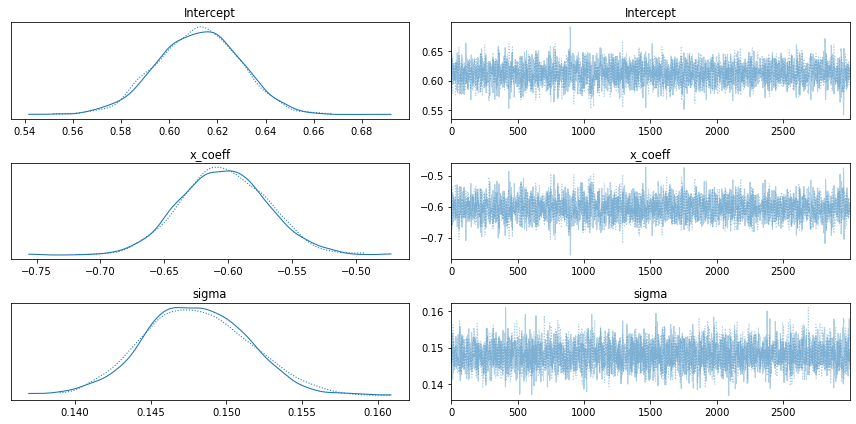

In [23]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout();

In [56]:
lin_x = list(np.linspace(0, 1, 21))
with model:
    pm.set_data(
        {
            "x": lin_x,
            # use dummy values with the same shape:
            "t": list(np.zeros_like(lin_x)),
        }
    )
    post_pred = pm.sample_posterior_predictive(idata.posterior)

4000
x: 0.1, mu: 0.5519361913559434, var: 0.021304431739955675


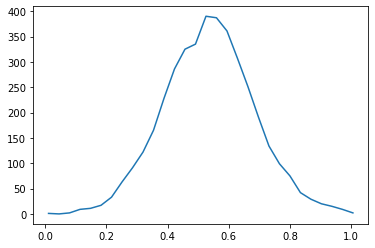

In [57]:
num = 2
print(len(post_pred['y'][:, num]))
dist = np.histogram(post_pred['y'][:, num], bins=30)
mu, var = np.average(post_pred['y'][:, num]), np.var(post_pred['y'][:, num])
print(f'x: {lin_x[num]}, mu: {mu}, var: {var}')
plt.plot(dist[1][:-1], dist[0])